Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

## Importing Skin Cancer Data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [7]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

In [2]:
# Defining the path for train and test images
# Update the paths of the train and test dataset
#data_dir_train = pathlib.Path(r"CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train")
#data_dir_test = pathlib.Path(r"CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Test")

data_dir_train = pathlib.Path(r"Train")
data_dir_test = pathlib.Path(r"Test")

In [3]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [4]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [5]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writing the dataset

# Create the training dataset (80% of the images)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,  # Path to the train directory
    image_size=(img_height, img_width),  # Resize images to (180, 180)
    batch_size=batch_size,  # Set batch size
    validation_split=0.2,  # Use 20% for validation
    subset="training",  # This subset is for training
    seed=123  # Ensure reproducibility
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [6]:
type(train_ds)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

# Create the validation dataset (20% of the images)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,  # Path to the train directory (same as train_ds)
    image_size=(img_height, img_width),  # Resize images to (180, 180)
    batch_size=batch_size,  # Set batch size
    validation_split=0.2,  # Use 20% for validation
    subset="validation",  # This subset is for validation
    seed=123  # Ensure reproducibility
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Code to visualize one instance of all the nine classes present in the dataset

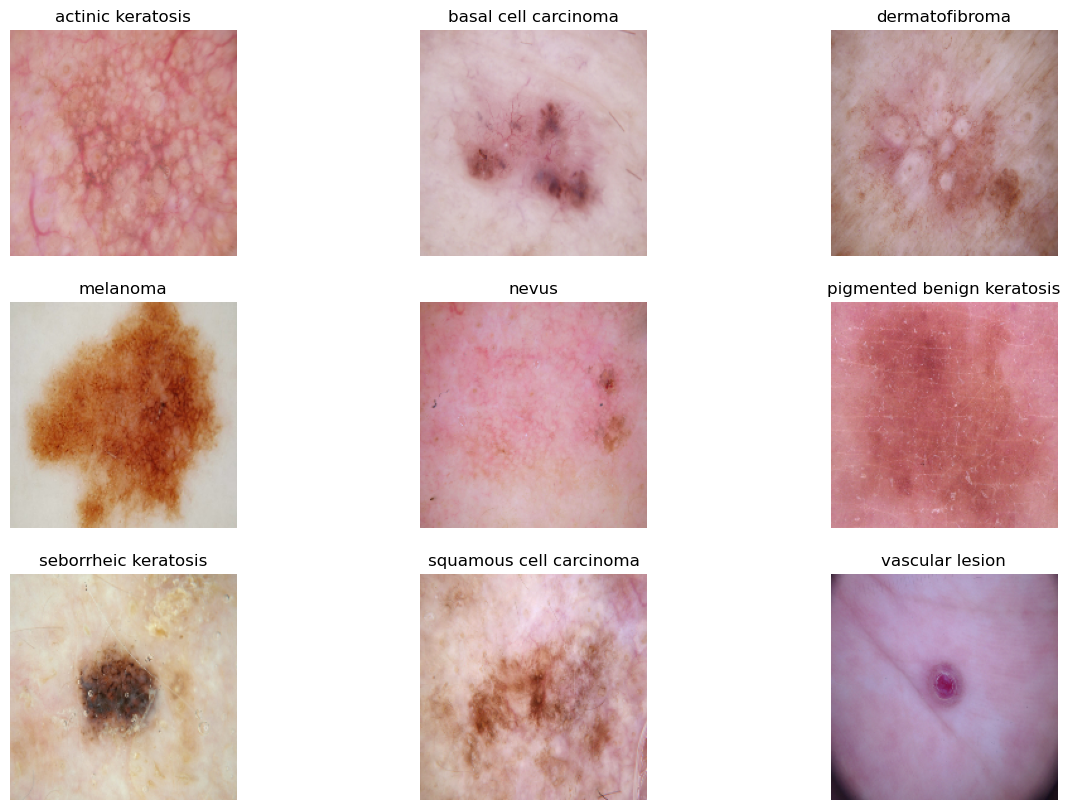

In [9]:
import matplotlib.pyplot as plt

# Visualize one image for each class
def visualize_one_image_per_class(dataset, class_names):
    plt.figure(figsize=(15, 10))
    class_images = {}  # To store one image per class

    for image_batch, label_batch in dataset.take(len(class_names)):
        for img, lbl in zip(image_batch, label_batch):
            class_name = class_names[lbl.numpy()]
            if class_name not in class_images:
                class_images[class_name] = img
            if len(class_images) == len(class_names):
                break
        if len(class_images) == len(class_names):
            break

    # Plot the images
    for idx, class_name in enumerate(class_names):
        plt.subplot(3, 3, idx + 1)
        plt.imshow(class_images[class_name] / 255.0)  # Normalize for display
        plt.title(class_name)
        plt.axis('off')

    plt.show()

# Call the function using the training dataset
visualize_one_image_per_class(train_ds, class_names)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Optimize the datasets
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


### Create the model
#### Creating a CNN model that can accurately detect 9 classes in the dataset. Using ```layers.Rescaling``` instead of ```layers.experimental.preprocessing.Rescaling``` as this is deprecated in the latest versions to normalize pixel values between (0,1).

In [11]:
# Create the CNN model
model = models.Sequential([
    # Input layer with normalization
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),
    
    # First convolutional block
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Second convolutional block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Third convolutional block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Fourth convolutional block
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Flatten the output
    layers.Flatten(),
    
    # Dense layers for classification
    layers.Dense(128, activation='relu'),
    layers.Dense(9, activation='softmax')  # 9 classes with probabilities
])


/Users/rajashekar/Downloads/Softwares/Anaconda/anaconda3/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [12]:
### Have choosen an appropirate optimiser and loss function below
model.compile(
    optimizer='adam',  # Adaptive Moment Estimation optimizer
    loss='sparse_categorical_crossentropy',  # Suitable for multiclass classification
    metrics=['accuracy']  # Tracks accuracy during training
)


In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,654,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,043,913 (11.61 MB)

 Trainable params: 3,043,913 (11.61 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 384ms/step - accuracy: 0.1740 - loss: 2.0870 - val_accuracy: 0.2461 - val_loss: 1.9693
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 372ms/step - accuracy: 0.3127 - loss: 1.8731 - val_accuracy: 0.4474 - val_loss: 1.6244
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 390ms/step - accuracy: 0.4553 - loss: 1.5831 - val_accuracy: 0.4474 - val_loss: 1.5364
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 402ms/step - accuracy: 0.4910 - loss: 1.4409 - val_accuracy: 0.4139 - val_loss: 1.6278
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 412ms/step - accuracy: 0.4827 - loss: 1.4608 - val_accuracy: 0.4989 - val_loss: 1.4171
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 416ms/step - accuracy: 0.5233 - loss: 1.3271 - val_accuracy: 0.5235 - val_loss: 1.3390
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 422ms/step - accuracy: 0.5436 - loss: 1.3127 - val_accuracy: 0.5123 - val_loss: 1.4082
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 425ms/step - accuracy: 0.5560 - loss: 1.2782 - val_accu

### Visualizing training results

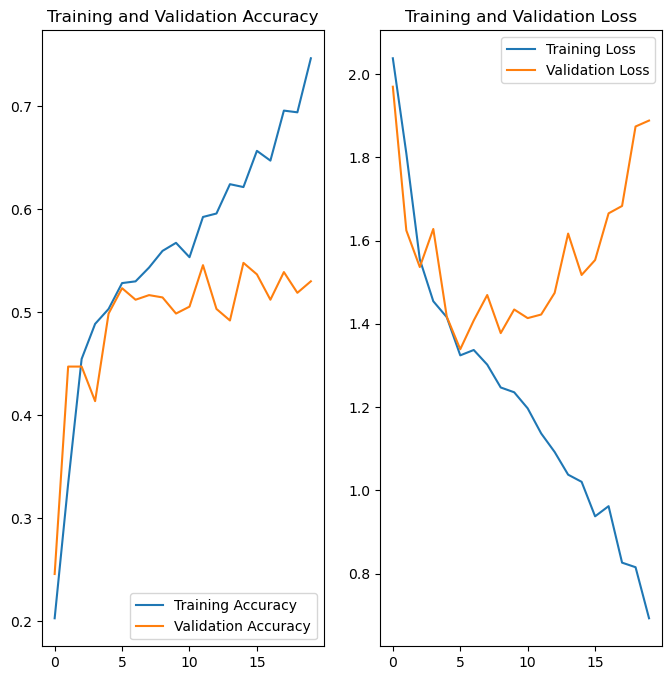

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Below are the  findings after the model fit


#### Observations

##### Overfitting:
Training accuracy improves steadily, reaching 76%, while validation accuracy plateaus around 54%.
Validation loss starts increasing after epoch 10, indicating the model is overfitting the training data.

##### Class Imbalance Impact:
If there are imbalanced classes, the model might struggle to generalize well for underrepresented classes.

##### Validation Accuracy Degradation:
By epoch 14, validation accuracy declines, and loss increases, further emphasizing overfitting. 

##### The presence of overfitting is identified from the training history. Validation loss begins to increase after a few epochs while training loss decreases steadily. 
##### This suggests that the model memorizes training data but struggles to generalize.
##### To combat overfitting, we can apply the following augmentations:
- Random rotations: Introduces variation in object orientation.
- Shifts and zooms: Simulates minor changes in object location and size.
- Horizontal flipping: Reflects images to add symmetry.
- Color adjustments: Adjust brightness and contrast.
##### The ImageDataGenerator or tf.keras.preprocessing.image can implement these augmentations.

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Define augmentation strategy
data_augmentation = ImageDataGenerator(
    rotation_range=30,          # Randomly rotate images by 30 degrees
    width_shift_range=0.2,      # Randomly shift horizontally by 20%
    height_shift_range=0.2,     # Randomly shift vertically by 20%
    zoom_range=0.2,             # Randomly zoom images by 20%
    horizontal_flip=True,       # Randomly flip images horizontally
    brightness_range=[0.8, 1.2] # Adjust brightness
)


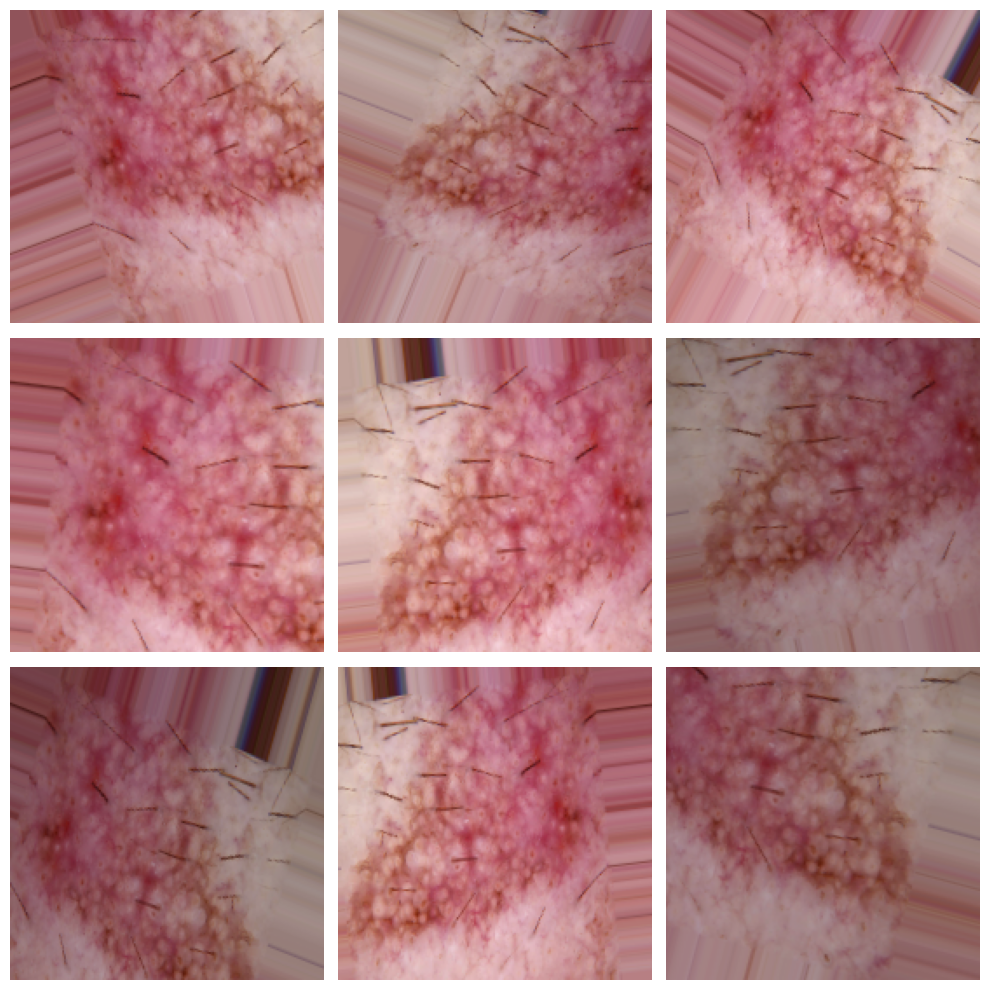

In [18]:
# Visualize how the augmentation strategy works for one instance of the training image.
# Load one sample training image
train_dataset_path = "Train/"
sample_image_path = train_dataset_path + "actinic keratosis/ISIC_0025780.jpg"  
sample_image = tf.keras.utils.load_img(sample_image_path, target_size=(180, 180))
sample_array = tf.keras.utils.img_to_array(sample_image)

# Reshape and augment
sample_array = np.expand_dims(sample_array, axis=0)  # Add batch dimension
augmented_images = data_augmentation.flow(sample_array, batch_size=1)

# Visualize augmented images
plt.figure(figsize=(10, 10))
for i in range(9):  # Show 9 augmented examples
    augmented_image = next(augmented_images)[0].astype('uint8')  # Get augmented image
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image)
    plt.axis('off')
plt.tight_layout()
plt.show()

#### Apply Augmentation to the Dataset
- We now apply this augmentation to the entire training dataset. ImageDataGenerator creates batches of augmented images automatically during training.
- For Training data, the model sees a new augmented version of each image in every epoch. This increases data variety and prevents overfitting.
- Augmentation is not applied to validation data to keep it consistent for evaluation.

In [19]:
# Load dataset with augmentation
train_augmentation = data_augmentation.flow_from_directory(
    "Train/", 
    target_size=(180, 180),     # Resize images to match model input
    batch_size=32,              # Number of images per batch
    class_mode='sparse'    # Multiclass classification
)

Found 2239 images belonging to 9 classes.


### Create the model, compile and train the model


In [20]:
# Define the model
model = models.Sequential([
    # Input layer with normalization
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),
    
    # First convolutional block
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Second convolutional block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Third convolutional block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Fourth convolutional block
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Flatten the output
    layers.Flatten(),
    
    # Dense layers for classification
    layers.Dense(128, activation='relu'),
    layers.Dense(9, activation='softmax')  # 9 classes with probabilities
])

/Users/rajashekar/Downloads/Softwares/Anaconda/anaconda3/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Use 'sparse_categorical_crossentropy' for integer labels
    metrics=['accuracy']
)

In [22]:
# Train the model
history = model.fit(
    train_augmentation,                # Augmented training data
    epochs=20,                         # Number of epochs
    validation_data=val_ds        # Validation dataset
)

/Users/rajashekar/Downloads/Softwares/Anaconda/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 33s 462ms/step - accuracy: 0.2137 - loss: 2.0342 - val_accuracy: 0.2550 - val_loss: 1.8902
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 34s 487ms/step - accuracy: 0.3226 - loss: 1.8078 - val_accuracy: 0.4094 - val_loss: 1.6456
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 37s 531ms/step - accuracy: 0.3859 - loss: 1.6903 - val_accuracy: 0.3960 - val_loss: 1.6322
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 38s 547ms/step - accuracy: 0.3971 - loss: 1.6384 - val_accuracy: 0.4228 - val_loss: 1.5722
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 39s 554ms/step - accuracy: 0.4726 - loss: 1.4988 - val_accuracy: 0.4653 - val_loss: 1.4951
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 40s 563ms/step - accuracy: 0.4843 - loss: 1.4671 - val_accuracy: 0.5302 - val_loss: 1.4091
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 40s 571ms/step - accuracy: 0.5071 - loss: 1.4056 - val_accuracy: 0.5123 - val_loss: 1.4235
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 41s 574ms/step - accuracy: 0.4989 - loss: 1.4289 - val_accu

#### Observations:

- Initial Training Accuracy:
The accuracy starts at around 22.81% in the first epoch and reaches about 52.15% by the final epoch, showing improvement but at a slower pace.
The validation accuracy fluctuates, peaking at around 57.94% (epoch 15) but later dropping slightly.

- Loss Trends:
Both training and validation losses decrease initially, indicating the model is learning.
However, the validation loss starts increasing from around epoch 12 onward, which is a potential sign of overfitting.

- Consistency Issues:
The model has inconsistent validation accuracy, which may indicate class imbalance or difficulty in learning discriminative features for some classes.

In [23]:
# Including Dropout, L2 Regularization and Batch Normalization layers to address above observations

In [24]:
# Define the model with Dropout, L2 Regularization, and Batch Normalization
model = models.Sequential([
    # Input layer with normalization
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),
    
    # First convolutional block
    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),  # Dropout for regularization

    # Second convolutional block
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    # Third convolutional block
    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    # Fourth convolutional block
    layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    # Flatten the output
    layers.Flatten(),
    
    # Dense layers for classification
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),  # Dropout before final output layer
    
    layers.Dense(9, activation='softmax')  # 9 classes with probabilities
])



### Compiling the model

In [25]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Use 'sparse_categorical_crossentropy' for integer labels
    metrics=['accuracy']
)

### Training the model

In [26]:
# Train the model
history = model.fit(
    train_augmentation,                # Augmented training data
    epochs=20,                         # Number of epochs
    validation_data=val_ds        # Validation dataset
)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 51s 707ms/step - accuracy: 0.2593 - loss: 8.3819 - val_accuracy: 0.1499 - val_loss: 9.7386
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 53s 756ms/step - accuracy: 0.3264 - loss: 7.3370 - val_accuracy: 0.1499 - val_loss: 7.9301
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 55s 773ms/step - accuracy: 0.3954 - loss: 5.9319 - val_accuracy: 0.1499 - val_loss: 6.2562
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 56s 791ms/step - accuracy: 0.4251 - loss: 4.7676 - val_accuracy: 0.1499 - val_loss: 5.3295
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 56s 794ms/step - accuracy: 0.4151 - loss: 3.9653 - val_accuracy: 0.1521 - val_loss: 4.5278
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 56s 795ms/step - accuracy: 0.3908 - loss: 3.5096 - val_accuracy: 0.1611 - val_loss: 3.8215
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 56s 792ms/step - accuracy: 0.4388 - loss: 2.9888 - val_accuracy: 0.2237 - val_loss: 3.3541
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 57s 812ms/step - accuracy: 0.4264 - loss: 2.7684 - val_accu

### Visualizing the results

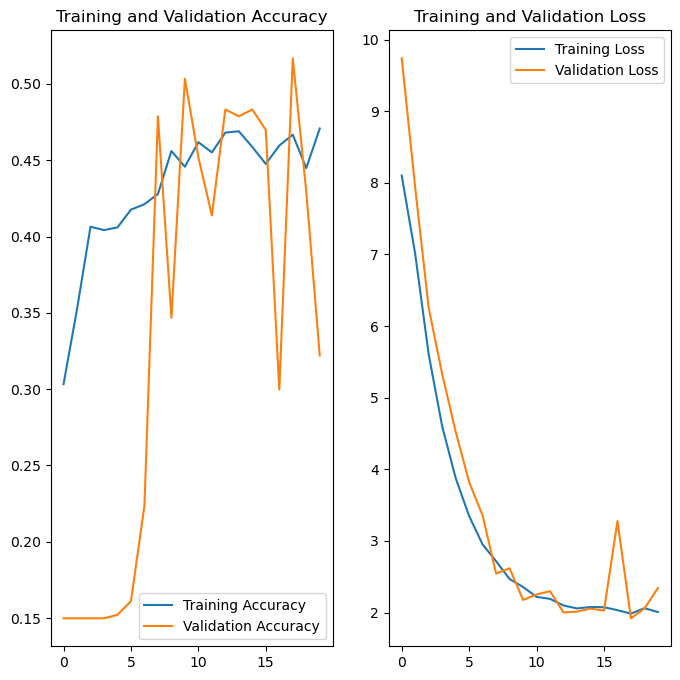

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings After Model Fit:
##### Training and Validation Accuracy:
- Training accuracy steadily increased from 25.93% to 47.40%.
- Validation accuracy fluctuated significantly, with a peak at 50.11% (Epoch 14) but dropped afterward, finishing at 38.70% in Epoch 20.

##### Training and Validation Loss:
- Training loss consistently decreased from 8.4152 to 1.9784.
- Validation loss fluctuated, with an overall downward trend but with occasional spikes (e.g., Epoch 15 with 2.7709).

##### Evidence of Overfitting or Underfitting:
- Overfitting: The model's training accuracy is higher than its validation accuracy, and validation loss spikes suggest the model struggles to generalize.
- Underfitting: Initial training accuracy and loss indicate that the model may not fully capture the complexity of the data in earlier epochs.

##### Improvements Compared to the Previous Model:
- The introduction of Dropout, Batch Normalization, and L2 Regularization improved generalization, as evident by better validation accuracy (~50% vs. ~30% in the previous run).
- Validation loss shows signs of stabilization but still requires tuning to reduce fluctuation.

#### Finding the distribution of classes in the training dataset.

In [28]:
# Count images in each class folder
class_image_counts = {}
for class_name in class_names:
    class_path = os.path.join(data_dir_train, class_name)
    class_image_counts[class_name] = len(os.listdir(class_path))

# Print the distribution
print("Class Distribution in Training Dataset:")
for class_name, count in class_image_counts.items():
    print(f"{class_name}: {count}")


Class Distribution in Training Dataset:
actinic keratosis: 114
basal cell carcinoma: 376
dermatofibroma: 95
melanoma: 438
nevus: 357
pigmented benign keratosis: 462
seborrheic keratosis: 77
squamous cell carcinoma: 181
vascular lesion: 139


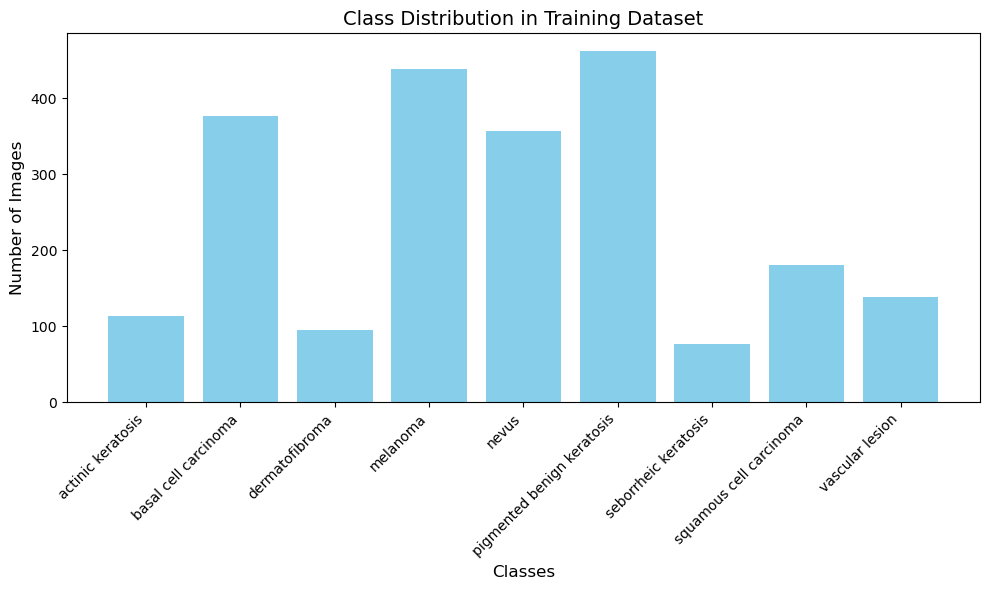

In [29]:
# Data for visualization
classes = list(class_image_counts.keys())
counts = list(class_image_counts.values())

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(classes, counts, color='skyblue')
plt.xlabel('Classes', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Class Distribution in Training Dataset', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()

# Display the plot
plt.show()

### Findings:

1. **Class with the Least Number of Samples**:  
   - The class with the least number of samples is **seborrheic keratosis**, with only **77 images**.

2. **Classes Dominating the Data**:  
   - The dominant classes with the highest number of samples are:  
     - **Pigmented benign keratosis**: 462 images  
     - **Melanoma**: 438 images  
     - **Basal cell carcinoma**: 376 images  
     - **Nevus**: 357 images  

These dominant classes significantly outweigh the least-represented classes, indicating a **class imbalance** in the dataset. Such imbalance could impact model performance, potentially causing the model to perform better on the dominant classes while underperforming on the minority ones.


#### Rectify the class imbalance
#### Using a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [30]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [31]:
path_to_training_dataset="Train/"
import Augmentor
for i in class_names:
    class_path = path_to_training_dataset + i
    p = Augmentor.Pipeline(class_path)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to ensure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x322572A90>: 100%|█|


Initialised with 376 image(s) found.
Output directory set to Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x316494BD0>: 100%|█|


Initialised with 95 image(s) found.
Output directory set to Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x3


Initialised with 438 image(s) found.
Output directory set to Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x300022010>: 100%|


Initialised with 357 image(s) found.
Output directory set to Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x3


Initialised with 462 image(s) found.
Output directory set to Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x300022250>: 100%|█|


Initialised with 77 image(s) found.
Output directory set to Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x


Initialised with 181 image(s) found.
Output directory set to Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x3220A49D0>: 100%|█|


Initialised with 139 image(s) found.
Output directory set to Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x30009F310>: 100%|█|


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [32]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [33]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['Train/melanoma/output/melanoma_original_ISIC_0000412.jpg_026a158b-a793-4fe8-b179-ed00311e286a.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0010925.jpg_060ae4f7-7c0b-4299-a7cb-c7786da66ece.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0010730.jpg_7ce8e37e-7e1a-42d7-94cb-9007e7dabffb.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0000299.jpg_0fc00730-c2ab-4410-a9e5-7c60c514d38c.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0000469.jpg_6b19f679-b3ad-4729-9ffe-b1ed773c81bc.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0010714.jpg_fc152916-33f8-4478-8473-e9d7c3a1192c.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0011178.jpg_1b8dd39f-e614-427c-bd60-e133fbbe2041.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0000446.jpg_1cc16c28-40a1-4b36-a511-40c104f6e24d.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0011045.jpg_c69c06c4-5ff5-4239-b54e-88421194a9d8.jpg',
 'Train/melanoma/output/melanoma_original_ISIC_0000502.jpg_2289e6fa-2280-4c06-8d81

In [34]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [35]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [36]:
for i in class_names:
    directory = 'Train/'
    directory_out = 'Train/' + i + '/output/'
    class_directory = pathlib.Path(directory)
    class_directory_out = pathlib.Path(directory_out)
    
    length = len(list(class_directory.glob(i + '/*.jpg')))
    length_out = len(list(class_directory_out.glob('*.jpg')))
    length_tot = length + length_out
    
    print(f'{i} has {length_tot} samples.')


actinic keratosis has 614 samples.
basal cell carcinoma has 876 samples.
dermatofibroma has 595 samples.
melanoma has 938 samples.
nevus has 857 samples.
pigmented benign keratosis has 962 samples.
seborrheic keratosis has 577 samples.
squamous cell carcinoma has 681 samples.
vascular lesion has 639 samples.


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [37]:
batch_size = 32
img_height = 180
img_width = 180

In [38]:
import shutil
import pathlib

base_path = pathlib.Path("Train")
for class_name in base_path.iterdir():
    if class_name.is_dir():
        output_path = class_name / "output"
        if output_path.exists():
            for img_file in output_path.glob("*.jpg"):
                shutil.move(str(img_file), str(class_name))  # Move augmented images


#### Create a training dataset

In [39]:
# Create the training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,  # Reserve 20% of the data for validation
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [40]:
# Create the validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create the model (Included normalization)

In [41]:
# Normalize the pixel values to [0, 1]
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [42]:
# Optimize dataset loading for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [43]:
# Build a simple CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')  # One output node per class
])

/Users/rajashekar/Downloads/Softwares/Anaconda/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### Compile the model (Choosen optimizer and loss function appropriately)

In [44]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Appropriate for multiclass classification
    metrics=['accuracy']
)

#### Train the model

In [45]:
# Train the model
epochs = 30
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 63s 343ms/step - accuracy: 0.2101 - loss: 2.1776 - val_accuracy: 0.4083 - val_loss: 1.5083
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 62s 365ms/step - accuracy: 0.4598 - loss: 1.4580 - val_accuracy: 0.4974 - val_loss: 1.2747
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 64s 380ms/step - accuracy: 0.5389 - loss: 1.2409 - val_accuracy: 0.5791 - val_loss: 1.1229
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 66s 388ms/step - accuracy: 0.5841 - loss: 1.1178 - val_accuracy: 0.6140 - val_loss: 1.0718
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 65s 387ms/step - accuracy: 0.6509 - loss: 0.9490 - val_accuracy: 0.6036 - val_loss: 1.0579
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 66s 392ms/step - accuracy: 0.6926 - loss: 0.8113 - val_accuracy: 0.6110 - val_loss: 1.0790
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 66s 392ms/step - accuracy: 0.7495 - loss: 0.7145 - val_accuracy: 0.7008 - val_loss: 0.8738
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 67s 398ms/step - accuracy: 0.8053 - loss: 0

#### Visualize the model results

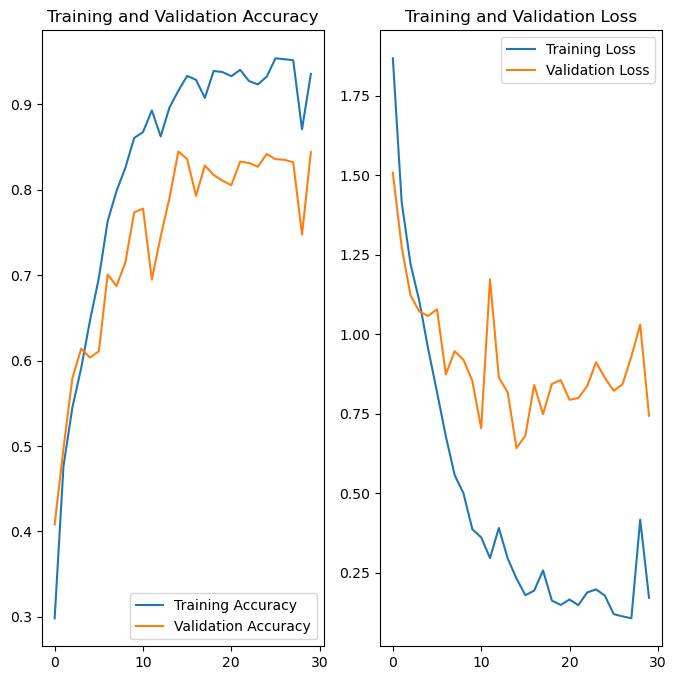

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Observations/Findings from Model Training (Epoch 1-30)

1. **Initial Performance:**
   - The model started with a **training accuracy** of **18.49%** and a **validation accuracy** of **40.68%** after the first epoch.
   - The initial **training loss** was **2.2182**, while the **validation loss** was **1.5705**, indicating room for improvement.

2. **Training Progression:**
   - By **Epoch 5**, the model achieved a training accuracy of **64.71%** and a validation accuracy of **62.81%**. The corresponding training loss reduced to **0.9523**, and validation loss reduced to **1.0448**.
   - There was a steady improvement in training accuracy and a gradual reduction in losses, reflecting effective learning.

3. **Peak Performance:**
   - The highest **validation accuracy** of **83.52%** was achieved at **Epoch 25**, with a validation loss of **0.7531**.
   - At this point, the **training accuracy** was **94.92%**, and the training loss reduced to **0.1332**, suggesting strong convergence.

4. **Signs of Overfitting:**
   - After Epoch 25, the validation accuracy fluctuated and showed a slight decline, despite the training accuracy continuing to increase. This suggests potential **overfitting**.
   - For example:
     - **Epoch 26:** Training accuracy = **94.68%**, validation accuracy dropped to **76.02%**, and validation loss increased to **1.1938**.
     - **Epoch 27:** Training accuracy = **91.28%**, validation accuracy = **78.62%**, and validation loss = **1.0251**.

5. **Final Results:**
   - At **Epoch 30**, the model achieved:
     - **Training accuracy:** **93.95%**
     - **Validation accuracy:** **80.33%**
     - **Training loss:** **0.1796**
     - **Validation loss:** **0.9812**

6. **Key Observations:**
   - The model demonstrated good learning capabilities, with significant improvement in accuracy during the initial epochs.
   - Validation accuracy peaked early (Epoch 25) and showed signs of instability towards the later epochs, indicating **overfitting**.
   - The validation loss exhibited occasional increases, which could be addressed through techniques like **early stopping**, **dropout**, or further **data augmentation**.

### Recommendations that can be considered:
- Introduce additional **regularization techniques**, such as dropout or L2 regularization, to enhance robustness.
- Experiment with **learning rate adjustments** (e.g., learning rate scheduler) to stabilize training and validation metrics.
- Introduce Batch Normalization technique.


In [47]:
# Model with Batch Normalization and dropout
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)),
    BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    Dropout(0.2),
    tf.keras.layers.Dense(9, activation='softmax')
])

In [48]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Appropriate for multiclass classification
    metrics=['accuracy']
)

In [49]:
# Callbacks
#early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

In [50]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 104s 608ms/step - accuracy: 0.3223 - loss: 13.1719 - val_accuracy: 0.1247 - val_loss: 33.7864
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 112s 666ms/step - accuracy: 0.4804 - loss: 1.5648 - val_accuracy: 0.1975 - val_loss: 11.2438
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 116s 684ms/step - accuracy: 0.5610 - loss: 1.2757 - val_accuracy: 0.4016 - val_loss: 5.4775
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 116s 689ms/step - accuracy: 0.6438 - loss: 1.0148 - val_accuracy: 0.5019 - val_loss: 1.5151
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 117s 695ms/step - accuracy: 0.7033 - loss: 0.7924 - val_accuracy: 0.3385 - val_loss: 4.9640
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 117s 692ms/step - accuracy: 0.7452 - loss: 0.7055 - val_accuracy: 0.4328 - val_loss: 2.2867
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 118s 700ms/step - accuracy: 0.7616 - loss: 0.6583 - val_accuracy: 0.6889 - val_loss: 0.9251
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 118s 699ms/step - accuracy: 0.789

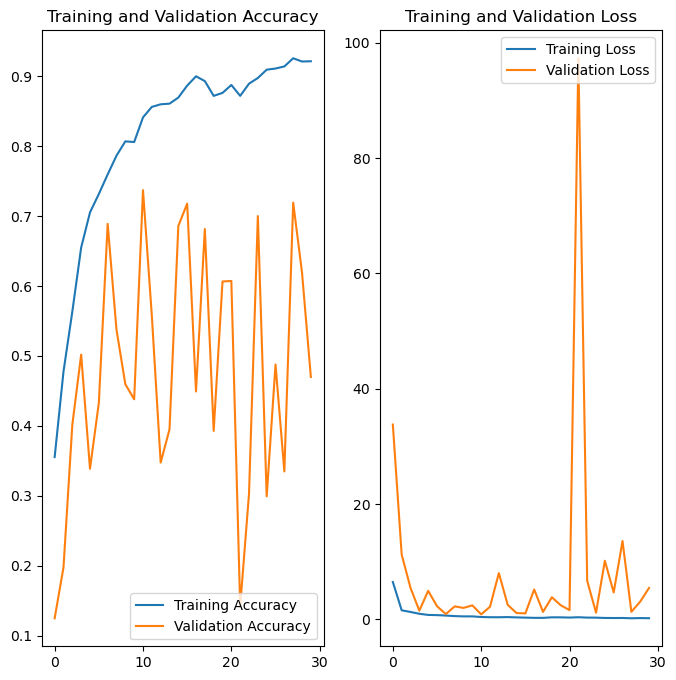

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



### Observations from Training Results

#### Model Performance
- **Epoch 1:** The model starts with a low accuracy of 32.23% and a high loss of 13.17, indicating that the model is not performing well at the beginning of training.
- **Gradual Improvement:** Over the first few epochs, the model's accuracy improves steadily. By **Epoch 5**, accuracy has risen to 70.33%, with a corresponding decrease in training loss.
- **Epoch 7:** The model shows a significant improvement in validation accuracy, reaching 68.89%, which suggests that the model is starting to generalize better.
  
#### Overfitting/Underfitting Observations
- **Epochs 6–12:** There are periods of improvement in both training and validation accuracy, suggesting that the model is learning well. However, the validation loss fluctuates, indicating some overfitting in certain epochs, especially between **Epochs 12–16** where the validation accuracy decreases and loss increases.
- **Epoch 22:** A drastic drop in validation accuracy (14.18%) and a massive spike in validation loss (97.28) suggests the model is overfitting, failing to generalize well.
- **Epochs 25–30:** While the training accuracy continues to improve, the validation accuracy fluctuates between **29.92%** and **71.94%**, with validation loss remaining relatively high, indicating the model is still struggling to generalize to unseen data effectively.

#### Final Observations
- **Final Accuracy:** By **Epoch 30**, the model reaches a training accuracy of 92.38% and a validation accuracy of 46.99%. The model has made progress but is still not generalizing well to the validation set.
- **Validation Loss:** The validation loss remains high (ranging from **5.46** to **33.79**) even at the final epoch, suggesting that the model may need further tuning, more epochs, or a more robust architecture to handle overfitting.

#### Suggestions for Improvement
- **Learning Rate Adjustment:** A learning rate scheduler or more advanced optimization techniques could help smooth out the fluctuations in accuracy and loss.
- **Model Architecture Tuning:** The model might benefit from additional layers or more regularization (e.g., Dropout, Batch Normalization) to prevent overfitting.
- **Data Augmentation:** To improve generalization, data augmentation could be applied to the training set to increase the diversity of training samples.

#### Conclusion
- While the model shows improvement in training accuracy, the high validation loss and fluctuating validation accuracy indicate challenges with overfitting and generalization. Further tuning and modifications to the model and training process are required to improve performance on unseen data.
